In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils
import IPython.display as ipd

In [2]:
data_np = np.load("./data/training/Scale.npy")
data_np_t= data_np.transpose() # first dimension is used to describe different data
data = torch.from_numpy(data_np_t)
import librosa
# hack solution- this should be loaded from some output file instead...
_, sr = librosa.load("./data/training/Scale.m4a")

/home/yasu/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


define dimensions for each layer

In [3]:
input_shape = data.shape[1]
hidden1_d = 200
hidden2_d = 40
latent_d = 3
print(f"{input_shape} -> {hidden1_d} -> {hidden2_d} -> {latent_d}")

1025 -> 200 -> 40 -> 3


define AutoEncoder model

In [4]:
ae_model = nn.Sequential(
    ## encoder
    nn.Linear(in_features=input_shape, out_features=hidden1_d),
    nn.ReLU(),
    nn.Linear(in_features=hidden1_d, out_features=hidden2_d),
    nn.ReLU(),
    nn.Linear(in_features=hidden2_d, out_features=latent_d),
    nn.ReLU(),
    ## decoder
    nn.Linear(in_features=latent_d, out_features=hidden2_d),
    nn.ReLU(),
    nn.Linear(in_features=hidden2_d, out_features=hidden1_d),
    nn.ReLU(),
    nn.Linear(in_features=hidden1_d, out_features=input_shape),
    nn.ReLU()
)

Plot initial output of the autoencoder (which will of course be gibberish)

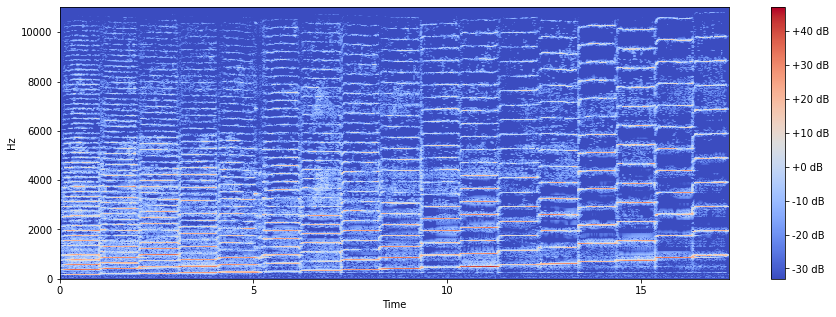

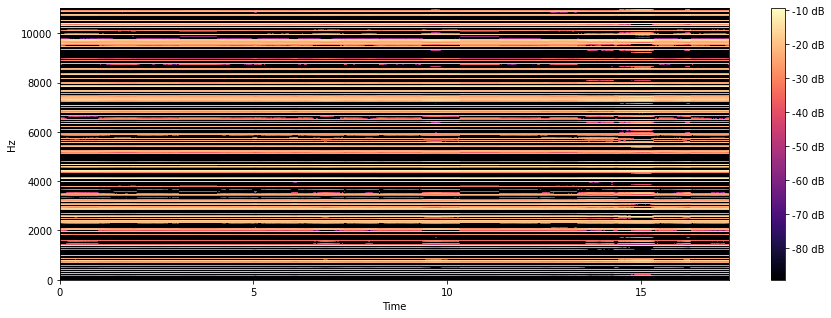

In [5]:
utils.plot_stft(data_np, sr)

initial_output = ae_model(data)
initial_output_np = initial_output.detach().numpy().transpose()
utils.plot_stft(initial_output_np, sr)

Horror sounds!

In [6]:
reconstructed_audio = utils.stft2audio(initial_output_np)
ipd.Audio(reconstructed_audio, rate=sr)

Just for fun, try it on the test data too

In [7]:
utils.test_ae_with_audio(["Brandenburg", "Canon in D"], ae_model)

playing Brandenburg...


/home/yasu/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Input audio:
samples:	248019
sampling rate:	22050
duration:	11.248027210884354
----------
Resulting STFT:
samples:	485
frequency is split into 1025 parts.


playing Canon in D...


/home/yasu/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Input audio:
samples:	501612
sampling rate:	22050
duration:	22.748843537414967
----------
Resulting STFT:
samples:	980
frequency is split into 1025 parts.


In [8]:
train_loader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)
learning_rate = 1e-4
optimizer = optim.Adam(ae_model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    loss = 0
    for inputs in train_loader:
        outputs = ae_model(inputs)
        train_loss = loss_fn(outputs, inputs)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss /= len(train_loader)
    if epoch % 40 == 0:
        print(f"Epoch:\t{epoch}\tLoss:\t{loss}")

Epoch:	0	Loss:	11.724879582722982
Epoch:	40	Loss:	5.768501694997152
Epoch:	80	Loss:	4.982073450088501
Epoch:	120	Loss:	4.87286270459493
Epoch:	160	Loss:	4.7360718727111815
Epoch:	200	Loss:	4.692241700490316
Epoch:	240	Loss:	4.665366665522257
Epoch:	280	Loss:	4.654699500401815
Epoch:	320	Loss:	4.62573618888855
Epoch:	360	Loss:	4.625901174545288
Epoch:	400	Loss:	4.594995053609212
Epoch:	440	Loss:	4.6107136885325115
Epoch:	480	Loss:	4.596538511912028
Epoch:	520	Loss:	4.590023295084635
Epoch:	560	Loss:	4.5724170207977295
Epoch:	600	Loss:	4.584167941411336
Epoch:	640	Loss:	4.572047503789266
Epoch:	680	Loss:	4.582565402984619
Epoch:	720	Loss:	4.57415026028951
Epoch:	760	Loss:	4.575464614232382
Epoch:	800	Loss:	4.546474552154541
Epoch:	840	Loss:	4.547373485565186
Epoch:	880	Loss:	4.550723997751872
Epoch:	920	Loss:	4.554379526774088
Epoch:	960	Loss:	4.565156364440918


In [9]:
utils.test_ae_with_audio(["Brandenburg", "Canon in D"], ae_model)

playing Brandenburg...


/home/yasu/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Input audio:
samples:	248019
sampling rate:	22050
duration:	11.248027210884354
----------
Resulting STFT:
samples:	485
frequency is split into 1025 parts.


playing Canon in D...


/home/yasu/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Input audio:
samples:	501612
sampling rate:	22050
duration:	22.748843537414967
----------
Resulting STFT:
samples:	980
frequency is split into 1025 parts.


That definitely went better than I expected...

Next, save the encoder / decoder models. I don't know how to split networks, so make new models for encoder and decoder, and manually copy the parameters to each...

In [30]:
print("keys for original model: ", ae_model.state_dict().keys())
encoder_model = nn.Sequential(
    ## encoder
    nn.Linear(in_features=input_shape, out_features=hidden1_d),
    nn.ReLU(),
    nn.Linear(in_features=hidden1_d, out_features=hidden2_d),
    nn.ReLU(),
    nn.Linear(in_features=hidden2_d, out_features=latent_d),
    nn.ReLU(),
)
encoder_model_dict = encoder_model.state_dict()
print("keys for encoder: ", encoder_model_dict.keys())
encoder_model_dict["0.weight"] = ae_model.state_dict()["0.weight"]
encoder_model_dict["0.bias"] = ae_model.state_dict()["0.bias"]
encoder_model_dict["2.weight"] = ae_model.state_dict()["2.weight"]
encoder_model_dict["2.bias"] = ae_model.state_dict()["2.bias"]
encoder_model_dict["4.weight"] = ae_model.state_dict()["4.weight"]
encoder_model_dict["4.bias"] = ae_model.state_dict()["4.bias"]
encoder_model.load_state_dict(encoder_model_dict)

keys for original model:  odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias', '8.weight', '8.bias', '10.weight', '10.bias'])
keys for encoder:  odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


<All keys matched successfully>

In [31]:
decoder_model = nn.Sequential(
    ## decoder
    nn.Linear(in_features=latent_d, out_features=hidden2_d),
    nn.ReLU(),
    nn.Linear(in_features=hidden2_d, out_features=hidden1_d),
    nn.ReLU(),
    nn.Linear(in_features=hidden1_d, out_features=input_shape),
    nn.ReLU()
)

decoder_model_dict = encoder_model.state_dict()
print("keys for decoder: ", encoder_model_dict.keys())
decoder_model_dict["0.weight"] = ae_model.state_dict()["6.weight"]
decoder_model_dict["0.bias"] = ae_model.state_dict()["6.bias"]
decoder_model_dict["2.weight"] = ae_model.state_dict()["8.weight"]
decoder_model_dict["2.bias"] = ae_model.state_dict()["8.bias"]
decoder_model_dict["4.weight"] = ae_model.state_dict()["10.weight"]
decoder_model_dict["4.bias"] = ae_model.state_dict()["10.bias"]
decoder_model.load_state_dict(decoder_model_dict)

keys for decoder:  odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


<All keys matched successfully>

In [32]:
directory = "./data/pytorch_model/"
torch.save(ae_model, f"{directory}encoder_decoder.pt")
torch.save(encoder_model, f"{directory}encoder.pt")
torch.save(decoder_model, f"{directory}decoder.pt")